In [56]:
import pandas as pd
import json
import numpy as np
from globals import BASE_DIR
#BASE_DIR = "/Users/andreaforster/dev/thesis/preprocessing/"
BASE_DIR = "/Volumes/Forster Neu/Masterarbeit Data/"
import os
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score


top_k_resample = 50
top_k_eval = 10

general_models = ["BPR", "SimpleX"]
context_models = ["LORE", "USG"]

available_datasets = ["brightkite", "foursquaretky", "snoward", "yelp"]

dataset = "yelp"

valid_popularity = "business_popularity:float"
#valid_popularity = "item_pop"

#recommendation_dirpart = "recommendations_with_cold_item_preprocessing"
recommendation_dirpart = "recommendations"

calibrate_on = "mean"

In [57]:
# Define the datasets you want to process
def dataset_metadata(dataset, recommendation_dirpart=recommendation_dirpart):
    data = []

    recs = os.listdir(f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}")
    if '.DS_Store' in recs:
        recs.remove('.DS_Store')

    for dir in recs:
        json_file = f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{dir}/general_evaluation.json"
        
        with open(json_file, 'r') as f:
            eval_data = json.load(f)
        
        # Extract the test_result data and flatten it
        test_results = eval_data.get("test_result", {})
        test_results["directory"] = dir

        test_results["dataset"] = test_results["directory"].split("-")[0]
        test_results["model"] = test_results["directory"].split("-")
        if test_results["directory"].split("-")[1] == "debias":
            test_results["model_type"] = "debias"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        
        elif test_results["directory"].split("-")[1] == "contextpoi":
            test_results["model_type"] = "contextpoi"
            test_results["date"] = "-".join(test_results["directory"].split("-")[3:])
        else:
            test_results["model_type"] = "general"
            test_results["date"] = "-".join(test_results["directory"].split("-")[2:])

        if test_results["model_type"] == "debias":
            test_results["model"] = test_results["model"][2]
        
        elif test_results["model_type"] == "contextpoi":
            test_results["model"] = test_results["model"][2]
            
        else:
            test_results["model"] = test_results["model"][1]

        if test_results["model"] == "MF":
            test_results["model_type"] = "general (via RecBole debias)"

        test_results["dataset"] = test_results["dataset"].split("_")[0]
        if test_results["model_type"] != "debias":
            data.append(test_results)

    return data


In [58]:
def open_ground_truth_user_group(dataset):
    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    return train_data, test_data,user_groups

In [59]:
def plot_popularity_distribution(ax, data, item_popularity, user_groups, label):
    # Merge the data
    data = data.merge(item_popularity, on="item_id:token", how="left")

    # Calculate normalized value counts for each user group
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")

    # Create a DataFrame from the Series
    distr_df = pd.DataFrame([g1, g2, g3]).fillna(0)  # Fill NaNs with 0 for missing groups

    # Specify the color order
    colors = ['blue', 'green', 'red']  # h, m, t colors in order

    # Plotting
    distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False)

    # Customize the plot
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Popularity Group Distribution")

    return g1, g2, g3




In [60]:
# def ndcg(test_data, df):
#     # Assign relevance scores to the ground truth items in test_data
#     test_data['relevance'] = 1
#     ndcg_scores = {}
#     for user_id in df['user_id:token'].unique():
#         recommended_items = df[df['user_id:token'] == user_id]['item_id:token'].tolist()

#         true_items = test_data[test_data['user_id:token'] == user_id]
#         true_relevance = [1 if item in true_items['item_id:token'].values else 0 for item in recommended_items]
#         ndcg = ndcg_score([true_relevance], [list(range(len(recommended_items), 0, -1))]) 
#         ndcg_scores[user_id] = ndcg
#     return ndcg_scores

def ndcg(test_data, df):
    test_data['relevance'] = 1
    ndcg_scores = {}

    for user_id in df['user_id:token'].unique():
        recommended_items = df[df['user_id:token'] == user_id]['item_id:token'].tolist()
        recommended_items = recommended_items[:top_k_eval]
        true_items = test_data[test_data['user_id:token'] == user_id]
    
        # Calculate the true relevance for each recommended item
        true_relevance = [1 if item in true_items['item_id:token'].values else 0 for item in recommended_items]
        
        dcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(true_relevance))
        
        # Calculate ideal DCG
        sorted_relevance = sorted(true_relevance, reverse=True)
        idcg = sum(rel / np.log2(idx + 2) for idx, rel in enumerate(sorted_relevance))
        
        ndcg = dcg / idcg if idcg > 0 else 0
        ndcg_scores[user_id] = ndcg

    return ndcg_scores

def calculate_arp_poplift(df, item_popularity, user_profile_popularity, valid_popularity=valid_popularity):
    df = df.merge(item_popularity, on="item_id:token", how="left")
    df = df.merge(user_profile_popularity, on="user_id:token", how="left")


    arp_scores = df.groupby('user_id:token')[valid_popularity].mean().to_dict()
    upts_scores = df.groupby('user_id:token')['upts'].mean().to_dict() 

    # Calculate poplift as the percentage deviation (ARP - UPP) / UPP for each user
    poplift_scores = {user_id: ((arp_scores[user_id] - upts_scores[user_id]) / upts_scores[user_id]) * 100 
                      for user_id in arp_scores if upts_scores[user_id] != 0}


    return arp_scores, poplift_scores



def calculate_deltas(test_data, base_df, calibrated_df, item_popularity, user_profile_popularity,model_name, valid_popularity=valid_popularity):
    base_ndcg_scores = ndcg(test_data, base_df)
    calibrated_ndcg_scores = ndcg(test_data, calibrated_df)    
    ndcg_delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
                        for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
    
    avg_ndcg_delta_percentage = abs(sum(ndcg_delta_percentage.values()) / len(ndcg_delta_percentage))

    base_arp_scores, base_poplift_scores = calculate_arp_poplift(base_df, item_popularity, user_profile_popularity, valid_popularity)
    calibrated_arp_scores, calibrated_poplift_scores = calculate_arp_poplift(calibrated_df, item_popularity, user_profile_popularity, valid_popularity)

    arp_delta_percentage = {user_id: ((calibrated_arp_scores[user_id] - base_arp_scores[user_id]) / base_arp_scores[user_id]) * 100 
                        for user_id in base_arp_scores if base_arp_scores[user_id] != 0}
    
    avg_arp_delta_percentage = abs(sum(arp_delta_percentage.values()) / len(arp_delta_percentage))

    poplift_delta_percentage = {user_id: ((calibrated_poplift_scores[user_id] - base_poplift_scores[user_id]) / base_poplift_scores[user_id]) * 100 
                        for user_id in base_poplift_scores if base_poplift_scores[user_id] != 0}
    
    avg_poplift_delta_percentage = abs(sum(poplift_delta_percentage.values()) / len(poplift_delta_percentage))

    print(f"{model_name} Base vs. Calibrated Results")
    print(f"Abs. nDCG % change: {avg_ndcg_delta_percentage:,.2f}%; base: {sum(base_ndcg_scores.values()) / len(base_ndcg_scores):,.5f}; calibrated: {sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores):,.5f}")
    print(f"Abs. ARP % change : {avg_arp_delta_percentage:,.2f}%; base: {sum(base_arp_scores.values()) / len(base_arp_scores):,.5f}; calibrated: {sum(calibrated_arp_scores.values()) / len(calibrated_arp_scores):,.5f}")
    print(f"Abs. Poplift % change : {avg_poplift_delta_percentage:,.2f}%; base: {sum(base_poplift_scores.values()) / len(base_poplift_scores):,.5f}; calibrated: {sum(calibrated_poplift_scores.values()) / len(calibrated_poplift_scores):,.5f}")
    print("*"*50)





def delta_ndcg_scores_by_group(test_data, base_df, calibrated_df, user_groups):
    group_deltas = {}
    for group_name, user_ids in user_groups.items():
        base_group = base_df[base_df['user_id:token'].isin(user_ids)]
        calibrated_group = calibrated_df[calibrated_df['user_id:token'].isin(user_ids)]
        base_ndcg_scores = ndcg(test_data, base_group)
        calibrated_ndcg_scores = ndcg(test_data, calibrated_group)
        
        delta_ndcg_scores = {user_id: calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id] 
                             for user_id in base_ndcg_scores}
        
        avg_delta = sum(delta_ndcg_scores.values()) / len(delta_ndcg_scores)
        
        delta_percentage = {user_id: ((calibrated_ndcg_scores[user_id] - base_ndcg_scores[user_id]) / base_ndcg_scores[user_id]) * 100 
                            for user_id in base_ndcg_scores if base_ndcg_scores[user_id] != 0}
                            
        
        avg_delta_percentage = sum(delta_percentage.values()) / len(delta_percentage)
        
        group_deltas[group_name] = {
            "avg_delta_ndcg": avg_delta,
            "avg_delta_percentage": avg_delta_percentage,
            "base_avg_ndcg": sum(base_ndcg_scores.values()) / len(base_ndcg_scores),
            "calibrated_avg_ndcg": sum(calibrated_ndcg_scores.values()) / len(calibrated_ndcg_scores)
        }
        
        print(f"Group: {group_name} - Average Delta nDCG Percentage: {avg_delta_percentage:.2f}%; "
              f"base nDCG: {group_deltas[group_name]['base_avg_ndcg']:.5f}; "
              f"calibrated nDCG: {group_deltas[group_name]['calibrated_avg_ndcg']:.5f}")
    print("*"*50)
    return group_deltas






In [61]:
def recommender_dir_combiner(dataset, modelpart):
    return f"{BASE_DIR}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/top_k_recommendations.json"


In [62]:
def base_vs_calibrate_creator(dataset, recommender_dir, top_k_resample=100, top_k_eval=10, valid_popularity=valid_popularity, calibrate_on="mean"):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    # max_count = value_counts["count"].max() 
    value_counts["item_pop"] = value_counts["count"] / len(value_counts) # the alternative is dividing it by the max_count
    checkin_df = checkin_df.merge(value_counts[["item_id:token", "item_pop"]], on = "item_id:token", how="left")
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[["item_id:token", valid_popularity]]

    h_group = item_popularity.head(int(len(item_popularity)*0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity)*0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[~item_popularity["item_id:token"].isin(h_group["item_id:token"]) & ~item_popularity["item_id:token"].isin(t_group["item_id:token"])]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group,m_group,t_group])
    # item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")
    checkin_df = checkin_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    checkin_df["upd"] = (checkin_df[valid_popularity] - checkin_df["upts"]).abs()

    checkin_df["upd"] = (checkin_df[valid_popularity] - checkin_df["upts"]).abs()




    # Calculate the UPTS (user popularity tolerance score)
    if calibrate_on == "mean":
        upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    else:
        upts = checkin_df.groupby("user_id:token")[valid_popularity].median().reset_index()

    upts.columns = ["user_id:token", "upts"]
    upts.sort_values("upts", ascending=False, inplace=True)

    with open(recommender_dir) as f:
        data = json.load(f)

    base_recommendations = {}
    for user, items in data.items():
        for item in items[:top_k_resample]:
            top_k_base = item["item_id"]
            base_recommendations[user] = top_k_base
            if len(top_k_base) < top_k_resample:
                print(f"{user} has less than {top_k_resample} recommendations --> ({len(top_k_base)})")


    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_recommendations.items() for item in items
    ])

    merged_df = base_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    merged_df["upd"] = (merged_df[valid_popularity] - merged_df["upts"]).abs()


    sorted_top_k_df = (
        merged_df.sort_values(by=["user_id:token", "upd"], ascending=True)
        .groupby("user_id:token")
        .head(top_k_resample)    # later back to top-k-eval
        .reset_index(drop=True)
    )

    calibrated_top_k_recommendations = (
        sorted_top_k_df.groupby("user_id:token")["item_id:token"]
        .apply(list)
        .to_dict()
    )

    base_top_k_recommendations = {}
    for user, items in base_recommendations.items():
        base_top_k_recommendations[user] = items[:top_k_resample]

    calibrated_top_k_recommendations.keys() == base_top_k_recommendations.keys()

    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_top_k_recommendations.items() for item in items
    ])

    calibrated_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in calibrated_top_k_recommendations.items() for item in items
    ])

    base_df.merge(item_popularity, on="item_id:token").value_counts("item_pop_group", normalize=True)
    return base_df, calibrated_df, item_popularity, upts #base_top_k_recommendations, calibrated_top_k_recommendations, 

In [63]:
def base_vs_calibrate_creator(dataset, recommender_dir, top_k_resample=100, valid_popularity=valid_popularity):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    # max_count = value_counts["count"].max() 
    value_counts["item_pop"] = value_counts["count"] / len(value_counts) # the alternative is dividing it by the max_count
    checkin_df = checkin_df.merge(value_counts[["item_id:token", "item_pop"]], on = "item_id:token", how="left")
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[["item_id:token", valid_popularity]]

    h_group = item_popularity.head(int(len(item_popularity)*0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity)*0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[~item_popularity["item_id:token"].isin(h_group["item_id:token"]) & ~item_popularity["item_id:token"].isin(t_group["item_id:token"])]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group,m_group,t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)

    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    upts.sort_values("upts", ascending=False, inplace=True)


    #checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left").merge(upts, on="user_id:token", how="left")


    with open(recommender_dir) as f:
        data = json.load(f)

    user_item_pairs = []
    # Iterate over the dictionary
    for user_id, items in data.items():
        for item_list in items:
            for item_id in item_list['item_id']:
                user_item_pairs.append({'user_id:token': user_id, 'item_id:token': item_id})

    # Convert the list of dictionaries to a DataFrame
    recommender_df = pd.DataFrame(user_item_pairs)

    checkin_df.drop(columns=["business_popularity:float", "item_pop"], inplace=True)
    checkin_df=checkin_df.merge(item_popularity, on="item_id:token", how="left")
    recommender_df=recommender_df.merge(item_popularity, on="item_id:token", how="left")
    recommender_df["baseline_item_rank_user"] = recommender_df.groupby("user_id:token").cumcount() + 1

    recommender_df = recommender_df.merge(upts, on="user_id:token", how="left")
    recommender_df["upd"] = (recommender_df[valid_popularity] - recommender_df["upts"]).abs()

    recommender_df.sort_values(by=["user_id:token", "upd"], ascending=True, inplace=True)
    recommender_df["reranked_item_rank_user"] = recommender_df.groupby("user_id:token").cumcount() + 1


    #return recommender_df


    # Calculate the UPTS (user popularity tolerance score)
    if calibrate_on == "mean":
        upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    else:
        upts = checkin_df.groupby("user_id:token")[valid_popularity].median().reset_index()

    upts.columns = ["user_id:token", "upts"]
    upts.sort_values("upts", ascending=False, inplace=True)

    with open(recommender_dir) as f:
        data = json.load(f)

    base_recommendations = {}
    for user, items in data.items():
        for item in items[:top_k_resample]:
            top_k_base = item["item_id"]
            base_recommendations[user] = top_k_base
            if len(top_k_base) < top_k_resample:
                print(f"{user} has less than {top_k_resample} recommendations --> ({len(top_k_base)})")


    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_recommendations.items() for item in items
    ])

    merged_df = base_df.merge(upts, on="user_id:token").merge(item_popularity, on="item_id:token")
    merged_df["upd"] = (merged_df[valid_popularity] - merged_df["upts"]).abs()


    sorted_top_k_df = (
        merged_df.sort_values(by=["user_id:token", "upd"], ascending=True)
        .groupby("user_id:token")
        .head(top_k_resample)    # later back to top-k-eval
        .reset_index(drop=True)
    )

    calibrated_top_k_recommendations = (
        sorted_top_k_df.groupby("user_id:token")["item_id:token"]
        .apply(list)
        .to_dict()
    )

    base_top_k_recommendations = {}
    for user, items in base_recommendations.items():
        base_top_k_recommendations[user] = items[:top_k_resample]

    calibrated_top_k_recommendations.keys() == base_top_k_recommendations.keys()

    base_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in base_top_k_recommendations.items() for item in items
    ])

    calibrated_df = pd.DataFrame([
        {"user_id:token": user, "item_id:token": item} for user, items in calibrated_top_k_recommendations.items() for item in items
    ])

    base_df.merge(item_popularity, on="item_id:token").value_counts("item_pop_group", normalize=True)
    return base_df, calibrated_df, item_popularity, upts #base_top_k_recommendations, calibrated_top_k_recommendations, 

In [64]:
data = dataset_metadata(dataset)
for result in data:
    if result["model"] == general_models[0]:
        general1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == general_models[1]:
        general2_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[0]:
        context1_dir = recommender_dir_combiner(dataset, result["directory"])
    elif result["model"] == context_models[1]:
        context2_dir = recommender_dir_combiner(dataset, result["directory"])

train_data, test_data, user_groups = open_ground_truth_user_group(dataset)
base_df_general1, calibrated_df_general1, item_popularity, upts = base_vs_calibrate_creator(dataset, general1_dir, top_k_resample, top_k_eval)
base_df_general2, calibrated_df_general2, item_popularity, upts = base_vs_calibrate_creator(dataset, general2_dir, top_k_resample, top_k_eval)
base_df_context1, calibrated_df_context1, item_popularity, upts = base_vs_calibrate_creator(dataset, context1_dir, top_k_resample, top_k_eval)
base_df_context2, calibrated_df_context2, item_popularity, upts = base_vs_calibrate_creator(dataset, context2_dir, top_k_resample, top_k_eval)

base_df_general1, calibrated_df_general1_med, item_popularity, upts_med = base_vs_calibrate_creator(dataset, general1_dir, top_k_resample, top_k_eval, calibrate_on="median")
base_df_general2, calibrated_df_general2_med, item_popularity, upts_med = base_vs_calibrate_creator(dataset, general2_dir, top_k_resample, top_k_eval, calibrate_on="median")
base_df_context1, calibrated_df_context1_med, item_popularity, upts_med = base_vs_calibrate_creator(dataset, context1_dir, top_k_resample, top_k_eval, calibrate_on="median")
base_df_context2, calibrated_df_context2_med, item_popularity, upts_med = base_vs_calibrate_creator(dataset, context2_dir, top_k_resample, top_k_eval, calibrate_on="median")


KeyError: 10

In [ ]:
recommender_df_general1= base_vs_calibrate_creator(dataset, general1_dir, top_k_resample, valid_popularity)
recommender_df_context1= base_vs_calibrate_creator(dataset, context1_dir, top_k_resample, valid_popularity)

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_9442/3976871074.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_9442/3976871074.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_9442/3976871074.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

UnboundLocalError: cannot access local variable 'upts' where it is not associated with a value

In [ ]:
recommender_df_context1.sort_values(by=["user_id:token", "reranked_item_rank_user"], ascending=True, inplace=True)

In [ ]:
user_groups["low"]

['455_x',
 '1477_x',
 '637_x',
 '1369_x',
 '1193_x',
 '164_x',
 '967_x',
 '223_x',
 '413_x',
 '785_x',
 '1013_x',
 '909_x',
 '468_x',
 '358_x',
 '382_x',
 '1455_x',
 '707_x',
 '390_x',
 '868_x',
 '1178_x',
 '442_x',
 '211_x',
 '670_x',
 '117_x',
 '459_x',
 '1054_x',
 '180_x',
 '366_x',
 '40_x',
 '72_x',
 '663_x',
 '470_x',
 '4_x',
 '1383_x',
 '584_x',
 '243_x',
 '921_x',
 '531_x',
 '585_x',
 '63_x',
 '473_x',
 '1252_x',
 '230_x',
 '463_x',
 '1025_x',
 '333_x',
 '1230_x',
 '730_x',
 '1097_x',
 '152_x',
 '372_x',
 '304_x',
 '288_x',
 '198_x',
 '88_x',
 '777_x',
 '471_x',
 '1074_x',
 '532_x',
 '950_x',
 '938_x',
 '1080_x',
 '474_x',
 '553_x',
 '309_x',
 '1435_x',
 '21_x',
 '485_x',
 '728_x',
 '613_x',
 '1075_x',
 '549_x',
 '807_x',
 '1269_x',
 '433_x',
 '1312_x',
 '888_x',
 '229_x',
 '1492_x',
 '120_x',
 '524_x',
 '1130_x',
 '1376_x',
 '469_x',
 '1475_x',
 '365_x',
 '954_x',
 '1287_x',
 '452_x',
 '505_x',
 '75_x',
 '798_x',
 '903_x',
 '1188_x',
 '533_x',
 '609_x',
 '285_x',
 '874_x',
 '12

In [ ]:
recommender_df_context1_g3 = recommender_df_context1.loc[recommender_df_context1["user_id:token"].isin(user_groups["low"])]
recommender_df_context1_g3.loc[recommender_df_context1_g3["upts"] == recommender_df_context1_g3["upts"].min()]

,user_id:token,item_id:token,business_popularity:float,item_pop_group,baseline_item_rank_user,upts,upd,reranked_item_rank_user
31570,311_x,3159_x,0.056522,m,21,0.058152,0.001630,1
31571,311_x,993_x,0.056522,m,22,0.058152,0.001630,2
31586,311_x,969_x,0.056522,m,37,0.058152,0.001630,3
31587,311_x,1723_x,0.056522,m,38,0.058152,0.001630,4
31588,311_x,2181_x,0.056522,m,39,0.058152,0.001630,5
31555,311_x,2052_x,0.060870,m,6,0.058152,0.002717,6
31560,311_x,756_x,0.060870,m,11,0.058152,0.002717,7
31575,311_x,2180_x,0.060870,m,26,0.058152,0.002717,8
31578,311_x,1292_x,0.060870,m,29,0.058152,0.002717,9
31585,311_x,2152_x,0.060870,m,36,0.058152,0.002717,10


In [ ]:
def calibrate_full_unseen_data(dataset, upts, item_popularity):
    checkin_df = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter", sep="\t")
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")

    train_data = pd.concat([train_data, valid_data], ignore_index=True)
    checkin_df = checkin_df.merge(item_popularity[["item_id:token", "item_pop_group"]], on="item_id:token", how="left")
    checkin_df = checkin_df.merge(upts, on="user_id:token", how="left")
    checkin_df["upd"] = (checkin_df[valid_popularity] - checkin_df["upts"]).abs()

    users = checkin_df['user_id:token'].unique()
    items = checkin_df['item_id:token'].unique()

    # create a df with all possible user-item combinations
    user_item_pairs = pd.MultiIndex.from_product([users, items], names=['user_id:token', 'item_id:token']).to_frame(index=False)

    full_users_items_df = user_item_pairs.merge(
        checkin_df[['user_id:token', 'upts']].drop_duplicates(), on='user_id:token', how='left'
    ).merge(
        checkin_df[['item_id:token', valid_popularity]].drop_duplicates(), on='item_id:token', how='left'
    )
    full_users_items_df['upd'] = (full_users_items_df[valid_popularity] - full_users_items_df['upts']).abs()

    filtered_checkins = full_users_items_df.merge(train_data[['user_id:token', 'item_id:token']], 
                                on=['user_id:token', 'item_id:token'], 
                                how='left', indicator=True)

    # Keep only pairs that do not appear in train_data
    filtered_checkins = filtered_checkins[filtered_checkins['_merge'] == 'left_only'].drop(columns=['_merge'])
    filtered_checkins = filtered_checkins.sort_values(by=["user_id:token", "upd"], ascending=True)
    

    top_k_eval_df = filtered_checkins.groupby("user_id:token").head(top_k_eval).reset_index(drop=True)

    return top_k_eval_df




In [ ]:
full_unseen_calibrate_df = calibrate_full_unseen_data(dataset, upts, item_popularity)

full_unseen_calibrate_df_median = calibrate_full_unseen_data(dataset, upts_med, item_popularity)

In [ ]:
def check_group_item_distribution(df, item_popularity, user_groups, upts):
    df["item_rank_user"] = df.groupby("user_id:token").cumcount() + 1
    g3 = df.loc[base_df_context1["user_id:token"].isin(user_groups["low"])].merge(item_popularity, on="item_id:token", how="left").merge(upts, on="user_id:token", how="left")
    g3 = g3.loc[g3["item_pop_group"] == "t"]
    return g3

    

In [ ]:
g3_base = check_group_item_distribution(base_df_context1, item_popularity, user_groups, upts)
g3_cal = check_group_item_distribution(calibrated_df_context1, item_popularity, user_groups, upts)

In [ ]:
g3_base

,user_id:token,item_id:token,item_rank_user,business_popularity:float,item_pop_group,upts
0,75_x,2997_x,1,0.043478,t,0.096640
5,75_x,3481_x,6,0.047826,t,0.096640
7,75_x,2286_x,8,0.043478,t,0.096640
9,75_x,3497_x,10,0.043478,t,0.096640
25,290_x,1826_x,6,0.043478,t,0.092153
...,...,...,...,...,...,...
4964,1445_x,4413_x,5,0.043478,t,0.093043
4966,1445_x,2966_x,7,0.043478,t,0.093043
4978,307_x,1996_x,9,0.043478,t,0.093720
4986,225_x,850_x,7,0.047826,t,0.094851


In [ ]:
g3_cal

,user_id:token,item_id:token,item_rank_user,business_popularity:float,item_pop_group,upts


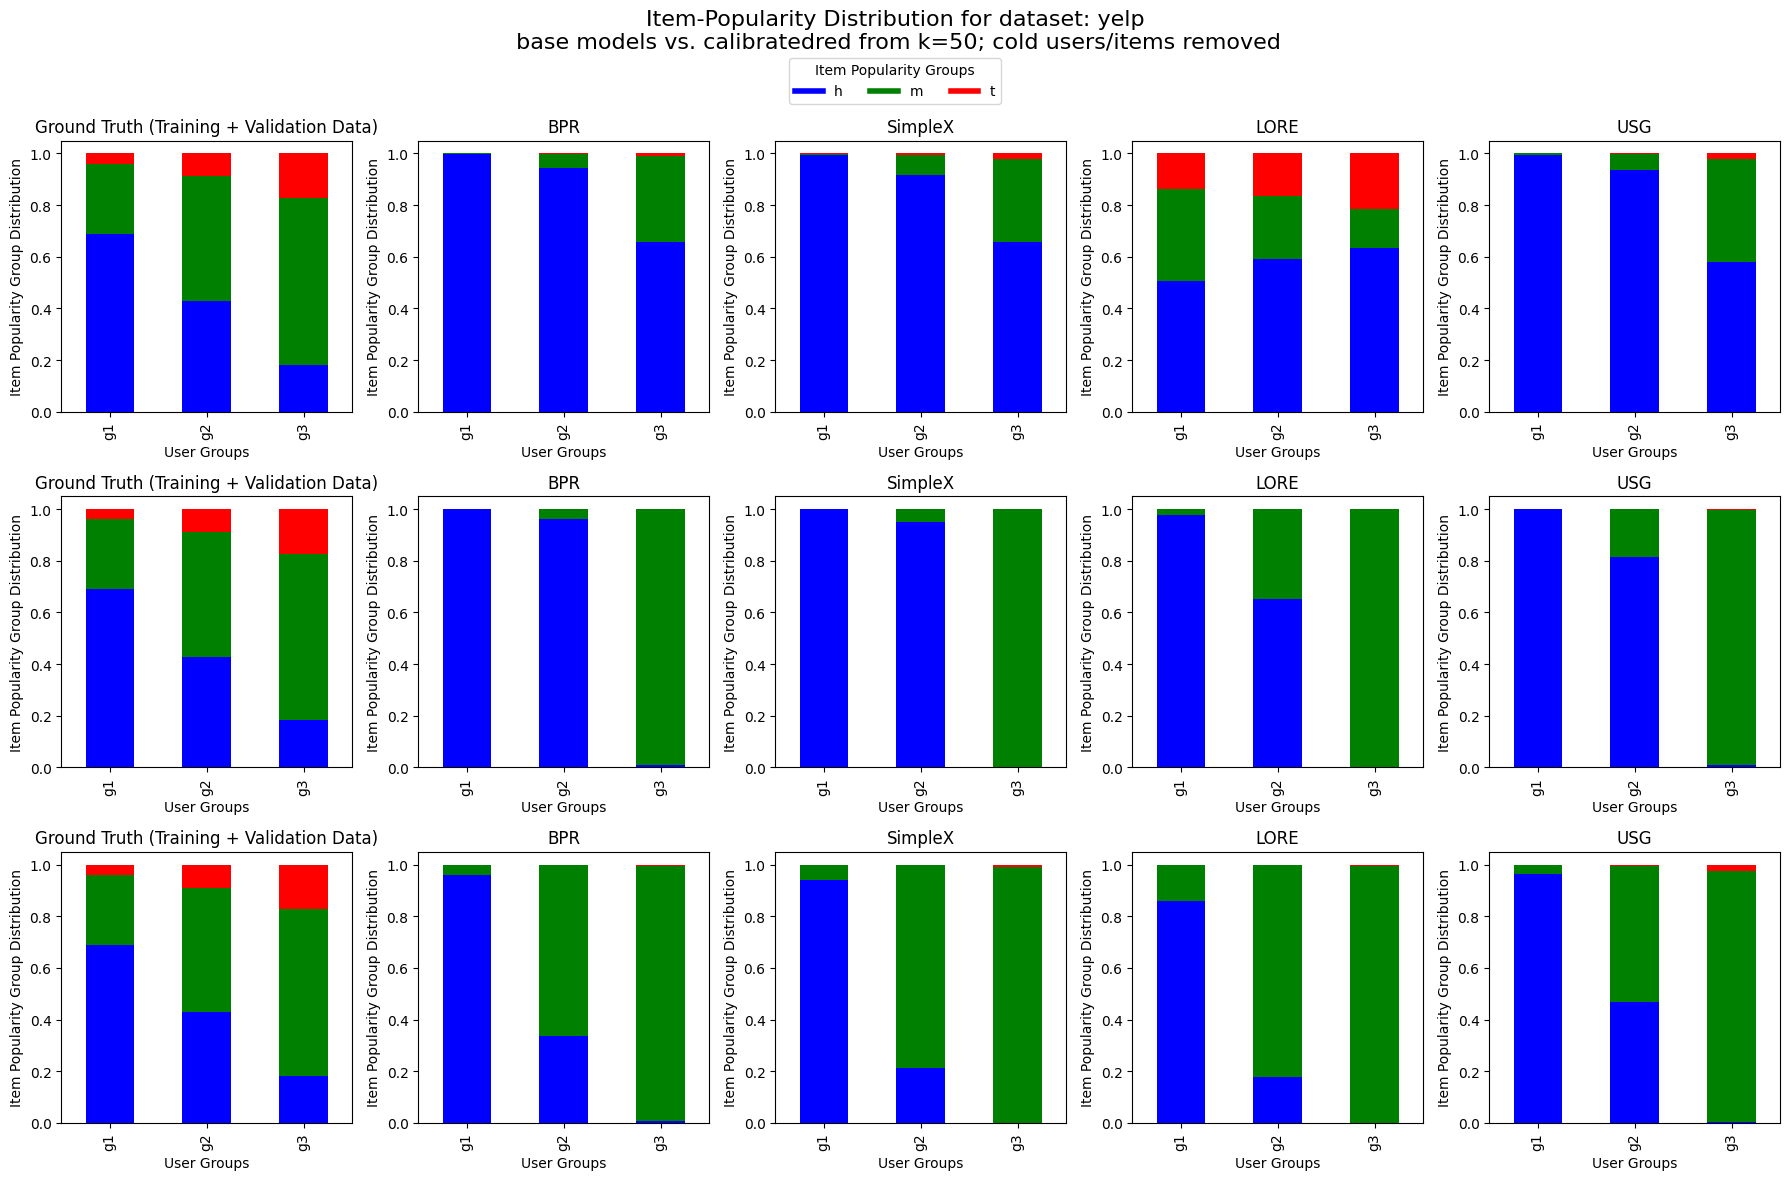

In [ ]:

fig, axs = plt.subplots(3, 5, figsize=(18, 12))  # 2 rows, 5 columns

# Base Models
plot_popularity_distribution(axs[0, 0], train_data, item_popularity, user_groups, "Ground Truth (Training + Validation Data)")
plot_popularity_distribution(axs[0, 1], base_df_general1, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[0, 2], base_df_general2, item_popularity, user_groups, general_models[1])
plot_popularity_distribution(axs[0, 3], base_df_context1, item_popularity, user_groups, context_models[0])
plot_popularity_distribution(axs[0, 4], base_df_context2, item_popularity, user_groups, context_models[1])

# Calibrated Models
plot_popularity_distribution(axs[1, 0], train_data, item_popularity, user_groups, "Ground Truth (Training + Validation Data)")
plot_popularity_distribution(axs[1, 1], calibrated_df_general1, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[1, 2], calibrated_df_general2, item_popularity, user_groups, general_models[1])
plot_popularity_distribution(axs[1, 3], calibrated_df_context1, item_popularity, user_groups, context_models[0])
plot_popularity_distribution(axs[1, 4], calibrated_df_context2, item_popularity, user_groups, context_models[1])

# Calibrated Models Median
plot_popularity_distribution(axs[2, 0], train_data, item_popularity, user_groups, "Ground Truth (Training + Validation Data)")
plot_popularity_distribution(axs[2, 1], calibrated_df_general1_med, item_popularity, user_groups, general_models[0])
plot_popularity_distribution(axs[2, 2], calibrated_df_general2_med, item_popularity, user_groups, general_models[1])
plot_popularity_distribution(axs[2, 3], calibrated_df_context1_med, item_popularity, user_groups, context_models[0])
plot_popularity_distribution(axs[2, 4], calibrated_df_context2_med, item_popularity, user_groups, context_models[1])

fig.suptitle(f"Item-Popularity Distribution for dataset: {dataset}\n base models vs. calibratedred from k={top_k_resample}; cold users/items removed", fontsize=16)

handles = [plt.Line2D([0], [0], color=color, lw=4) for color in ['blue', 'green', 'red']]
labels = ['h', 'm', 't']
fig.legend(handles, labels, title="Item Popularity Groups", loc='upper center', bbox_to_anchor=(0.5, 0.945), ncol=3)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_distribution.png")
plt.show()

In [ ]:
print(f"Dataset: {dataset}")
print("Base Algorithm vs. Mean-based Calibration")
calculate_deltas(test_data, base_df_general1, calibrated_df_general1, item_popularity, upts, general_models[0])
calculate_deltas(test_data, base_df_general2, calibrated_df_general2, item_popularity, upts, general_models[1])
calculate_deltas(test_data, base_df_context1, calibrated_df_context1, item_popularity, upts, context_models[0])
calculate_deltas(test_data, base_df_context2, calibrated_df_context2, item_popularity, upts, context_models[1])

print(f"Dataset: {dataset}")
print("Base Algorithm vs. Median-based Calibration")
calculate_deltas(test_data, base_df_general1, calibrated_df_general1_med, item_popularity, upts_med, general_models[0])
calculate_deltas(test_data, base_df_general2, calibrated_df_general2_med, item_popularity, upts_med, general_models[1])
calculate_deltas(test_data, base_df_context1, calibrated_df_context1_med, item_popularity, upts_med, context_models[0])
calculate_deltas(test_data, base_df_context2, calibrated_df_context2_med, item_popularity, upts_med, context_models[1])


#calculate_deltas(test_data, base_df_general1, full_unseen_calibrate_df, item_popularity, upts, f"{general_models[0]} vs. Full Unseen Sort")


Dataset: yelp
Base Algorithm vs. Mean-based Calibration
BPR Base vs. Calibrated Results
Abs. nDCG % change: 81.66%; base: 0.12711; calibrated: 0.05552
Abs. ARP % change : 53.99%; base: 0.40625; calibrated: 0.16327
Abs. Poplift % change : 99.18%; base: 159.85655; calibrated: 0.17900
**************************************************
SimpleX Base vs. Calibrated Results
Abs. nDCG % change: 85.22%; base: 0.12254; calibrated: 0.05511
Abs. ARP % change : 52.52%; base: 0.40351; calibrated: 0.16267
Abs. Poplift % change : 100.32%; base: 159.44007; calibrated: -0.31410
**************************************************
LORE Base vs. Calibrated Results
Abs. nDCG % change: 48.27%; base: 0.07215; calibrated: 0.09002
Abs. ARP % change : 43.45%; base: 0.10651; calibrated: 0.14591
Abs. Poplift % change : 108.73%; base: -26.61994; calibrated: -8.07649
**************************************************
USG Base vs. Calibrated Results
Abs. nDCG % change: 75.25%; base: 0.12765; calibrated: 0.07333
Abs. A

In [ ]:
user_groups

{'high': ['1479_x',
  '1496_x',
  '234_x',
  '815_x',
  '1427_x',
  '510_x',
  '1440_x',
  '737_x',
  '1481_x',
  '1276_x',
  '1359_x',
  '940_x',
  '1099_x',
  '1090_x',
  '370_x',
  '1307_x',
  '1348_x',
  '1419_x',
  '962_x',
  '1391_x',
  '1226_x',
  '1207_x',
  '1303_x',
  '610_x',
  '84_x',
  '918_x',
  '1180_x',
  '1334_x',
  '590_x',
  '33_x',
  '362_x',
  '1483_x',
  '1040_x',
  '1322_x',
  '1175_x',
  '1182_x',
  '236_x',
  '1081_x',
  '1176_x',
  '573_x',
  '326_x',
  '843_x',
  '25_x',
  '729_x',
  '560_x',
  '506_x',
  '1262_x',
  '1498_x',
  '1012_x',
  '761_x',
  '633_x',
  '1432_x',
  '1434_x',
  '860_x',
  '1055_x',
  '1499_x',
  '574_x',
  '804_x',
  '734_x',
  '1357_x',
  '915_x',
  '1374_x',
  '22_x',
  '752_x',
  '1382_x',
  '409_x',
  '1311_x',
  '1426_x',
  '90_x',
  '1431_x',
  '1026_x',
  '656_x',
  '1444_x',
  '1140_x',
  '1298_x',
  '646_x',
  '1149_x',
  '794_x',
  '1375_x',
  '644_x',
  '1319_x',
  '1305_x',
  '1258_x',
  '948_x',
  '1345_x',
  '1356_x',
  

In [ ]:
# group_deltas_general1 = delta_scores_by_group(test_data=test_data, base_df=base_df_general1, calibrated_df=calibrated_df_general1, item_popularity=item_popularity, user_profile_popularity=upts, valid_popularity=valid_popularity, user_groups=user_groups)
# group_deltas_general2 = delta_scores_by_group(test_data, base_df_general2, calibrated_df_general2, user_groups)
# group_deltas_context1 = delta_scores_by_group(test_data, base_df_context1, calibrated_df_context1, user_groups)
# group_deltas_context2 = delta_scores_by_group(test_data, base_df_context2, calibrated_df_context2, user_groups)

In [ ]:
# group_deltas_general1 = delta_scores_by_group(test_data, base_df_general1, calibrated_df_general1_med, user_groups)
# group_deltas_general2 = delta_scores_by_group(test_data, base_df_general2, calibrated_df_general2_med, user_groups)
# group_deltas_context1 = delta_scores_by_group(test_data, base_df_context1, calibrated_df_context1_med, user_groups)
# group_deltas_context2 = delta_scores_by_group(test_data, base_df_context2, calibrated_df_context2_med, user_groups)